[Leo's Home page](https://leomrocha.github.com) -- [Github Page](https://github.com/leomrocha/neural-representations) -- License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

# Representations of Vectors on Non Spiking Networks


[Leonardo M. Rocha](https://leomrocha.github.com)

[Contact Me](https://leomrocha.github.io/contact/)

## Introduction

The goal of the present text is to introduce and explore how to encode and decode *Vectors* based on the mechanisms and principles presented in [An Introduction to Scalar Representations in Neural Models](https://leomrocha.github.io/neural-representations/NeuralModels-Introduction.html) but trying to go into a non-spiking networks. 

This document presents a small study on how a vector can be encoded by a non-linear function in a Non-Spiking Neural Ensemble and then decoded with a linear function.

The following sections expose the source code in between the explanations on what is done. For more exploration and to be able to execute the code the original notebook can be found [here](https://github.com/leomrocha/neural-representations/blob/main/notebooks/VectorRepresentation_tests.ipynb).

In [1]:
import random
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

%matplotlib inline

## Goal

As with the previous scalar representation the goal here is to be able to randomly create neurons and synapses and be able to find a linear decoder that is able to correctly decode the non-linear encoded value.

To do this, in this section, instead of considering that the neuron has only one input and one output, I'll start playing with synapse weights. 

The goal is to understand how to generate different synapse weights (with some random values of a certain distribution) without the need to train the system, and only finding (training) the linear decoder.

## First Vector Representation Experience

The main point of this notebook is to understand how to represent nicely vectors with the same neuron populations as the Scalars.

For this exercise I'll start considering that the input current is limited to the range [-1;1] and this implies that bigger currents (module) than this can not be represented.
This means that if the input is saturated by one of the synapses, the other synapses contributions to the neural input current will be maybe ignored.

I propose the following ideas to study the behaviour:

* All synapse values are equal and the sum is 1
* Uniform random distribution of the variables, where all synapse values add to a maximum of 1 (one), this might be done doing the synapse weights first [0,1], then [0,1-s1], [0,1-s1-s2], .... ,[0,1-s1-s2-....-sn] .. this might be good to take into account negative numbers too
* Gaussian distribution (attention) for each neuron on the input values of the input vector
* Try other distributions (as attention) to input values of the vector

**Questions**:

 - Should I use NEGATIVE synapse values? -> tried uniform random and NO, it does not work better in simple scenarios
 - If so: How to take care of NEGATIVE synapse values?

### Case Study - All synapses sum 1




In [2]:
class VectorNeuron(object):
    def __init__(self, a, b, sat, weights):
        self.a = a
        self.b = b
        self.saturation = sat
        self.weights = weights

In [3]:
# redefining the vector creation function to allow for the neurons different totally random synapse weights

def rand_vector_neuron_creation(n_synapses, min_y=0.5, max_y=1.5,
                                min_weight=0.0, max_weight=0.8,  # to experiment with the weight limits
                                min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    max_w = 0.9  # I don understand the error in random when passing the param by arg
    if(saturation is None):
        saturation = random.uniform(0.8, 1.0)
    s = random.choice([-1, 1])
    a = b = 0
    # the first point is for y=0
    x1 = random.uniform(-1, 1)
    y1 = 0
    # the second point is for x=+-1
    x2 = s
    y2 = random.uniform(min_y, max_y)

    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    # weights = [random.uniform(0, 0.8) for s in range(n_synapses)] #do the test with synapse weight = 1
    weights = [random.uniform(min_weight, max_w) for s in range(
        n_synapses)]  # do the test with synapse weight = 1
    return VectorNeuron(a, b, saturation, np.array(weights))


# now redefine the weights function here, so I can redo the study
vector_neuron_creation = rand_vector_neuron_creation

## Important NOTE:

I tried with min_weight values of -1.0, -0.9 and 0.0

The value 0 clearly outperforms the negative values, giving min_weight to the synapse weight should be then the value 0.0 (zero)

In [4]:
min_weight = -0.8
max_weight = 0.8

random.uniform(min_weight, max_weight)

-0.7287449757727759

In [5]:
# Definition of function evaluation

def limited_vector_neuron_evaluator(x, neuron):
    a = neuron.a
    b = neuron.b
    sat=neuron.saturation
    current = np.minimum(x,np.ones(x.shape)).transpose().dot(neuron.weights)
    return max(0, min(a*current + b, sat))
    

def vector_neuron_evaluator(x, neuron):
    a = neuron.a
    b = neuron.b
    sat = neuron.saturation
    current = np.minimum(x,np.ones(x.shape)).transpose().dot(neuron.weights)
    return max(0, a*current + b)

In [6]:
class VectorEnsemble(object):
    def __init__(self, vect_dimension, n_neurons, min_y=0.5, max_y=1.5, max_x=1,min_x=-1, saturation=None):
        self.neurons = [vector_neuron_creation(vect_dimension, min_y, max_y, max_x, saturation) for i in range(n_neurons)]

    def encode_saturation(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = limited_vector_neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return np.array(output)
    
    def encode(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = vector_neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return np.array(output)

In [7]:
#make ensembles for different dimensions, the ensambles will have 1000 neurons each
#dimensions is the input dimension of the function
ensembles = []

#dimensions = [2,3,5,10,20,50,100,1000, 10000]
dimensions = [2,3,4,10]

nneurons=500

for d in dimensions:
    ensembles.append(VectorEnsemble(d, nneurons))

In [8]:
npoints = 10000
xt = np.linspace(0, 8*np.pi, npoints)

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 14.4 ms


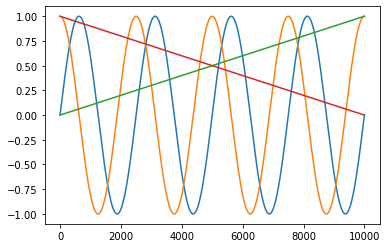

In [9]:
%%time

fsin = np.sin(xt)
fcos = np.cos(xt)
xlasc = np.linspace(0,1,npoints)
xldes = np.linspace(1,0,npoints)

ind4 = np.column_stack((fsin, fcos, xlasc, xldes))

plt.plot(range(npoints), ind4);

In [10]:
%%time

ins = ind4 #inputs[0]
ens = ensembles[2]

encs = ens.encode_saturation(ind4)
encns = ens.encode(ind4)

CPU times: user 31.5 s, sys: 197 ms, total: 31.7 s
Wall time: 31.7 s


In [11]:
n_vectors = npoints 

inputs = [np.random.rand(n_vectors,d) for d in dimensions]

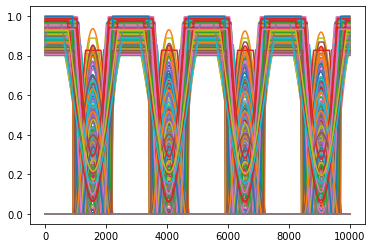

In [12]:
plt.plot(range(n_vectors), encs);

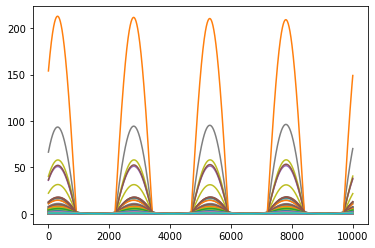

In [13]:
plt.plot(range(n_vectors), encns);

Seems that a few particular values are taking control of all the elements.

I think I should ALSO limit the Post Synaptic Current (PSC) for each connexion

0.5745651063853169


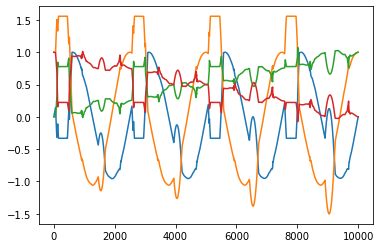

In [14]:
decoders = []

ntrain = 50

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-203485279.22357273


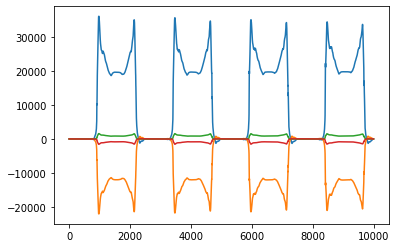

In [15]:
decoders = []

ntrain = 200

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-75242982250.54074


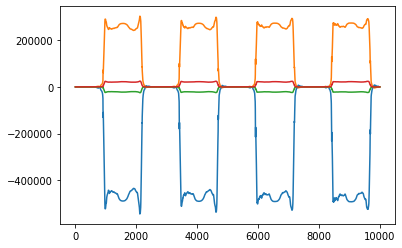

In [16]:
decoders = []

ntrain = 300

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-1.280085013309198e+28


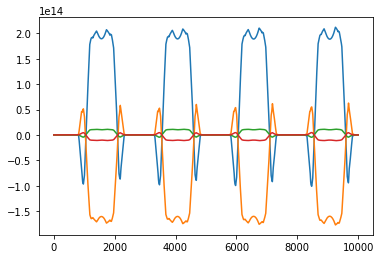

In [17]:
decoders = []

ntrain = 500

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-1.6291537746785135e+21


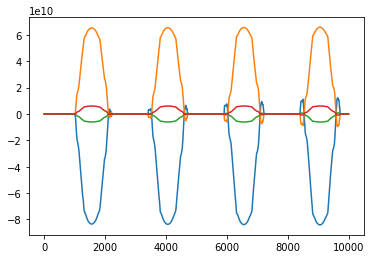

In [18]:
decoders = []

ntrain = 1000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-1694139.1932548117


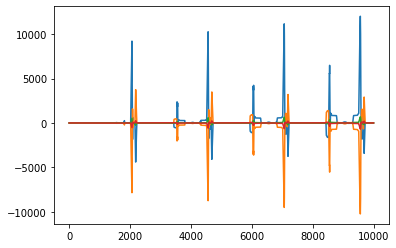

In [19]:
decoders = []

ntrain = 1500

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-955363.4255255609


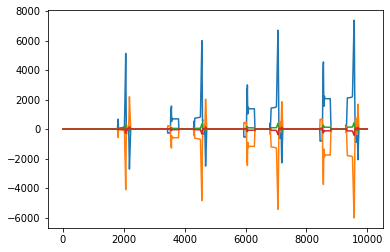

In [20]:
decoders = []

ntrain = 1750

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-137039.31787429014


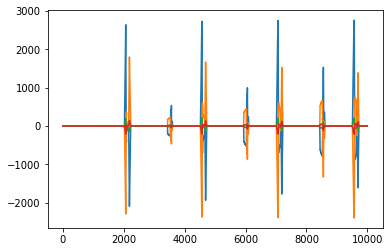

In [21]:
decoders = []

ntrain = 2000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-0.496049645940724


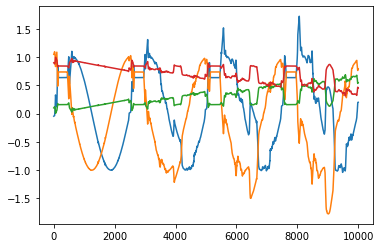

In [22]:
decoders = []

ntrain = 3000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

0.2615004306269731


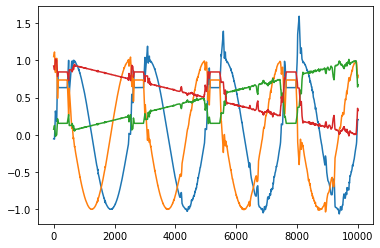

In [23]:
decoders = []

ntrain = 4000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-0.20737280130422903


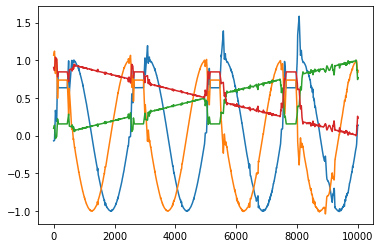

In [24]:
decoders = []

ntrain = 5000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

0.008479578939236898


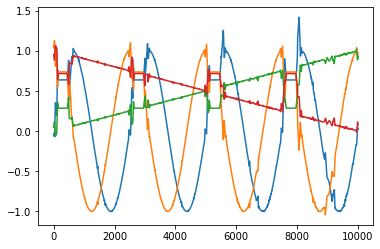

In [25]:
decoders = []

ntrain = 6000

lm = linear_model.LinearRegression()
model = lm.fit(encs[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encs[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encs));

-2.5346177132958685


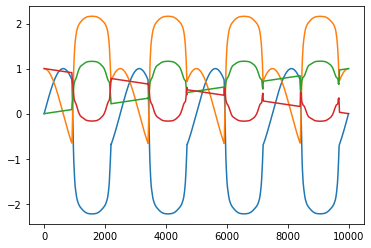

In [26]:
#and now I try with unlimited neuron output

decoders = []

ntrain = 500

lm = linear_model.LinearRegression()
model = lm.fit(encns[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encns[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encns));

0.9998611469375359


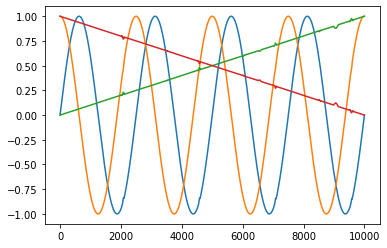

In [27]:
#and now I try with unlimited neuron output

decoders = []

ntrain = 2000

lm = linear_model.LinearRegression()
model = lm.fit(encns[:ntrain],ins[:ntrain])
    

#now evaluate the results with those numbers
print (model.score(encns[ntrain:], ins[ntrain:]))
    
plt.plot(range(n_vectors), model.predict(encns));

Limited current neuron outperforms the non limited one, but the difference does not seems to be too much.

The main point of limiting the neuron output I think is to avoid divergence, I'd rather have more noise than divergence

##  Important NOTE

The number of neurons in the ensemble, plus the number of training elements plays a huge rol in the results of the decoder

I'll try now with random points in higer dimension spaces

In [28]:
%%time

#make ensembles for different dimensions, the ensambles will have 1000 neurons each
#dimensions is the input dimension of the function
ensembles = {}
rand_values = {}
#dimensions = [10,20,50,100,1000, 5000, 10000]
dimensions = [2, 3, 4, 10, 20, 100]
nsamples=10000
nneurons = [10,20,50,100,1000]

for d in dimensions:
    for ns in nneurons:
        if d not in ensembles.keys():
            ensembles[d] = {}
        if d not in rand_values.keys():
            rand_values[d] = {}
        ensembles[d][ns] = VectorEnsemble(d, ns)
        rand_values[d][ns] = np.random.rand(nsamples,d)



CPU times: user 82.3 ms, sys: 6.19 ms, total: 88.4 ms
Wall time: 87.6 ms


In [29]:
%%time

encoded = {}

for d in dimensions:
    for ns in nneurons:
        if d not in encoded.keys():
            rnd = rand_values[d][ns]
            encoded[d] = {}
        ens = ensembles[d][ns]
        encoded[d][ns] = ens.encode_saturation(rnd)
    

CPU times: user 3min 45s, sys: 373 ms, total: 3min 45s
Wall time: 3min 45s


In [30]:
%%time
#I'm curious about the 
#and now I do a grid search to check on the performances on random numbers for each of the 

models = []
decoded = []
scores = []


results = []

ntrain = [50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000]


for n in ntrain:
    for d in dimensions:
        for ns in nneurons:
            encs = encoded[d][ns].copy()
            ins = rand_values[d][ns].copy()
            lm = linear_model.LinearRegression()
            model = lm.fit(encs[:n].copy(),ins[:n])
            s = model.score(encs[n:], ins[n:])
            dec = model.predict(encs[n:])
            models.append([n, d, ns, model])
            scores.append([n, d, ns, s])
            decoded.append([n, d, ns, dec])


CPU times: user 4min 3s, sys: 2min 53s, total: 6min 56s
Wall time: 1min


In [31]:
scoresdf = pd.DataFrame(scores)

In [32]:
scoresdf.describe()

,0,1,2,3
count,450.000000,450.000000,450.000000,4.500000e+02
mean,1886.666667,23.166667,236.000000,-9.824647e+47
std,2005.932182,34.940691,383.707154,1.462596e+49
min,50.000000,2.000000,10.000000,-2.866630e+50
25%,300.000000,3.000000,20.000000,-2.517598e+21
50%,1000.000000,7.000000,50.000000,-1.330211e+17
75%,3000.000000,20.000000,100.000000,-3.893543e-02
max,7000.000000,100.000000,1000.000000,5.646187e-01


I am not sure how to interpret this just yet, I'll have to double check on the results and try to make some sens of it.

It seems that for certain values, the regression of RANDOM values is really great, but for the others, is really bad. This seems to be related to the number of dimensions .... 2 dimensions is great but more seems bad?

I don get the difference of results with the previous graphs ...

- Is it related with the number of neurons?
- Is it related to the number of training samples?
- Is it some other thing that I don't understand?




In [33]:
scoresdf[abs(scoresdf[3]) <= 1][abs(scoresdf[3]) >= 0.5]


<ipython-input-33-a6e95717cd06>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scoresdf[abs(scoresdf[3]) <= 1][abs(scoresdf[3]) >= 0.5]


,0,1,2,3
0,50,2,10,0.503192
1,50,2,20,-0.541856
36,100,3,20,-0.619506
40,100,4,10,-0.728265
60,200,2,10,0.540922
90,300,2,10,0.549399
120,400,2,10,0.556609
150,500,2,10,0.555990
180,750,2,10,0.555194
210,1000,2,10,0.557304


It seems that the random values do not give too much meaning .... there is something to see here then.

It might be able to decode functions, but random points dont seem to make sense ... ?

I have to dig that more in depth ...

Also, it seems that the higher the dimension the more difficult is to find a nice decoder